In [297]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_absolute_percentage_error

In [223]:
pip install xgboost

     ---------------------------------------- 99.7/99.7 MB 4.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [300]:
df = pd.read_csv('Energy.csv')# add respective to the data file
data = df

In [301]:
df.columns

Index(['Start time UTC', 'End time UTC', 'Start time UTC+03:00',
       'End time UTC+03:00', 'Electricity consumption in Finland'],
      dtype='object')

In [302]:
df = df.drop(columns=['End time UTC', 'Start time UTC+03:00',
       'End time UTC+03:00'])


In [303]:
df = df.rename(columns={'Start time UTC': 'DateTime', 'Electricity consumption in Finland': 'Consumption'})
df.index = pd.to_datetime(df['DateTime'])

# Extracting features

In [304]:
df["Month"] = pd.to_datetime(df["DateTime"]).dt.month
df["Year"] = pd.to_datetime(df["DateTime"]).dt.year
df["Date"] = pd.to_datetime(df["DateTime"]).dt.date
df["Time"] = pd.to_datetime(df["DateTime"]).dt.time
df["Week"] = pd.to_datetime(df["DateTime"]).dt.week
df["Day"] = pd.to_datetime(df["DateTime"]).dt.day_name()
df["Hour"] = pd.to_datetime(df["DateTime"]).dt.hour

C:\Users\ianme\AppData\Local\Temp\ipykernel_26312\982971349.py:5: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df["Week"] = pd.to_datetime(df["DateTime"]).dt.week


In [305]:
df = df.drop(columns=['DateTime'])

In [306]:
dataset = df

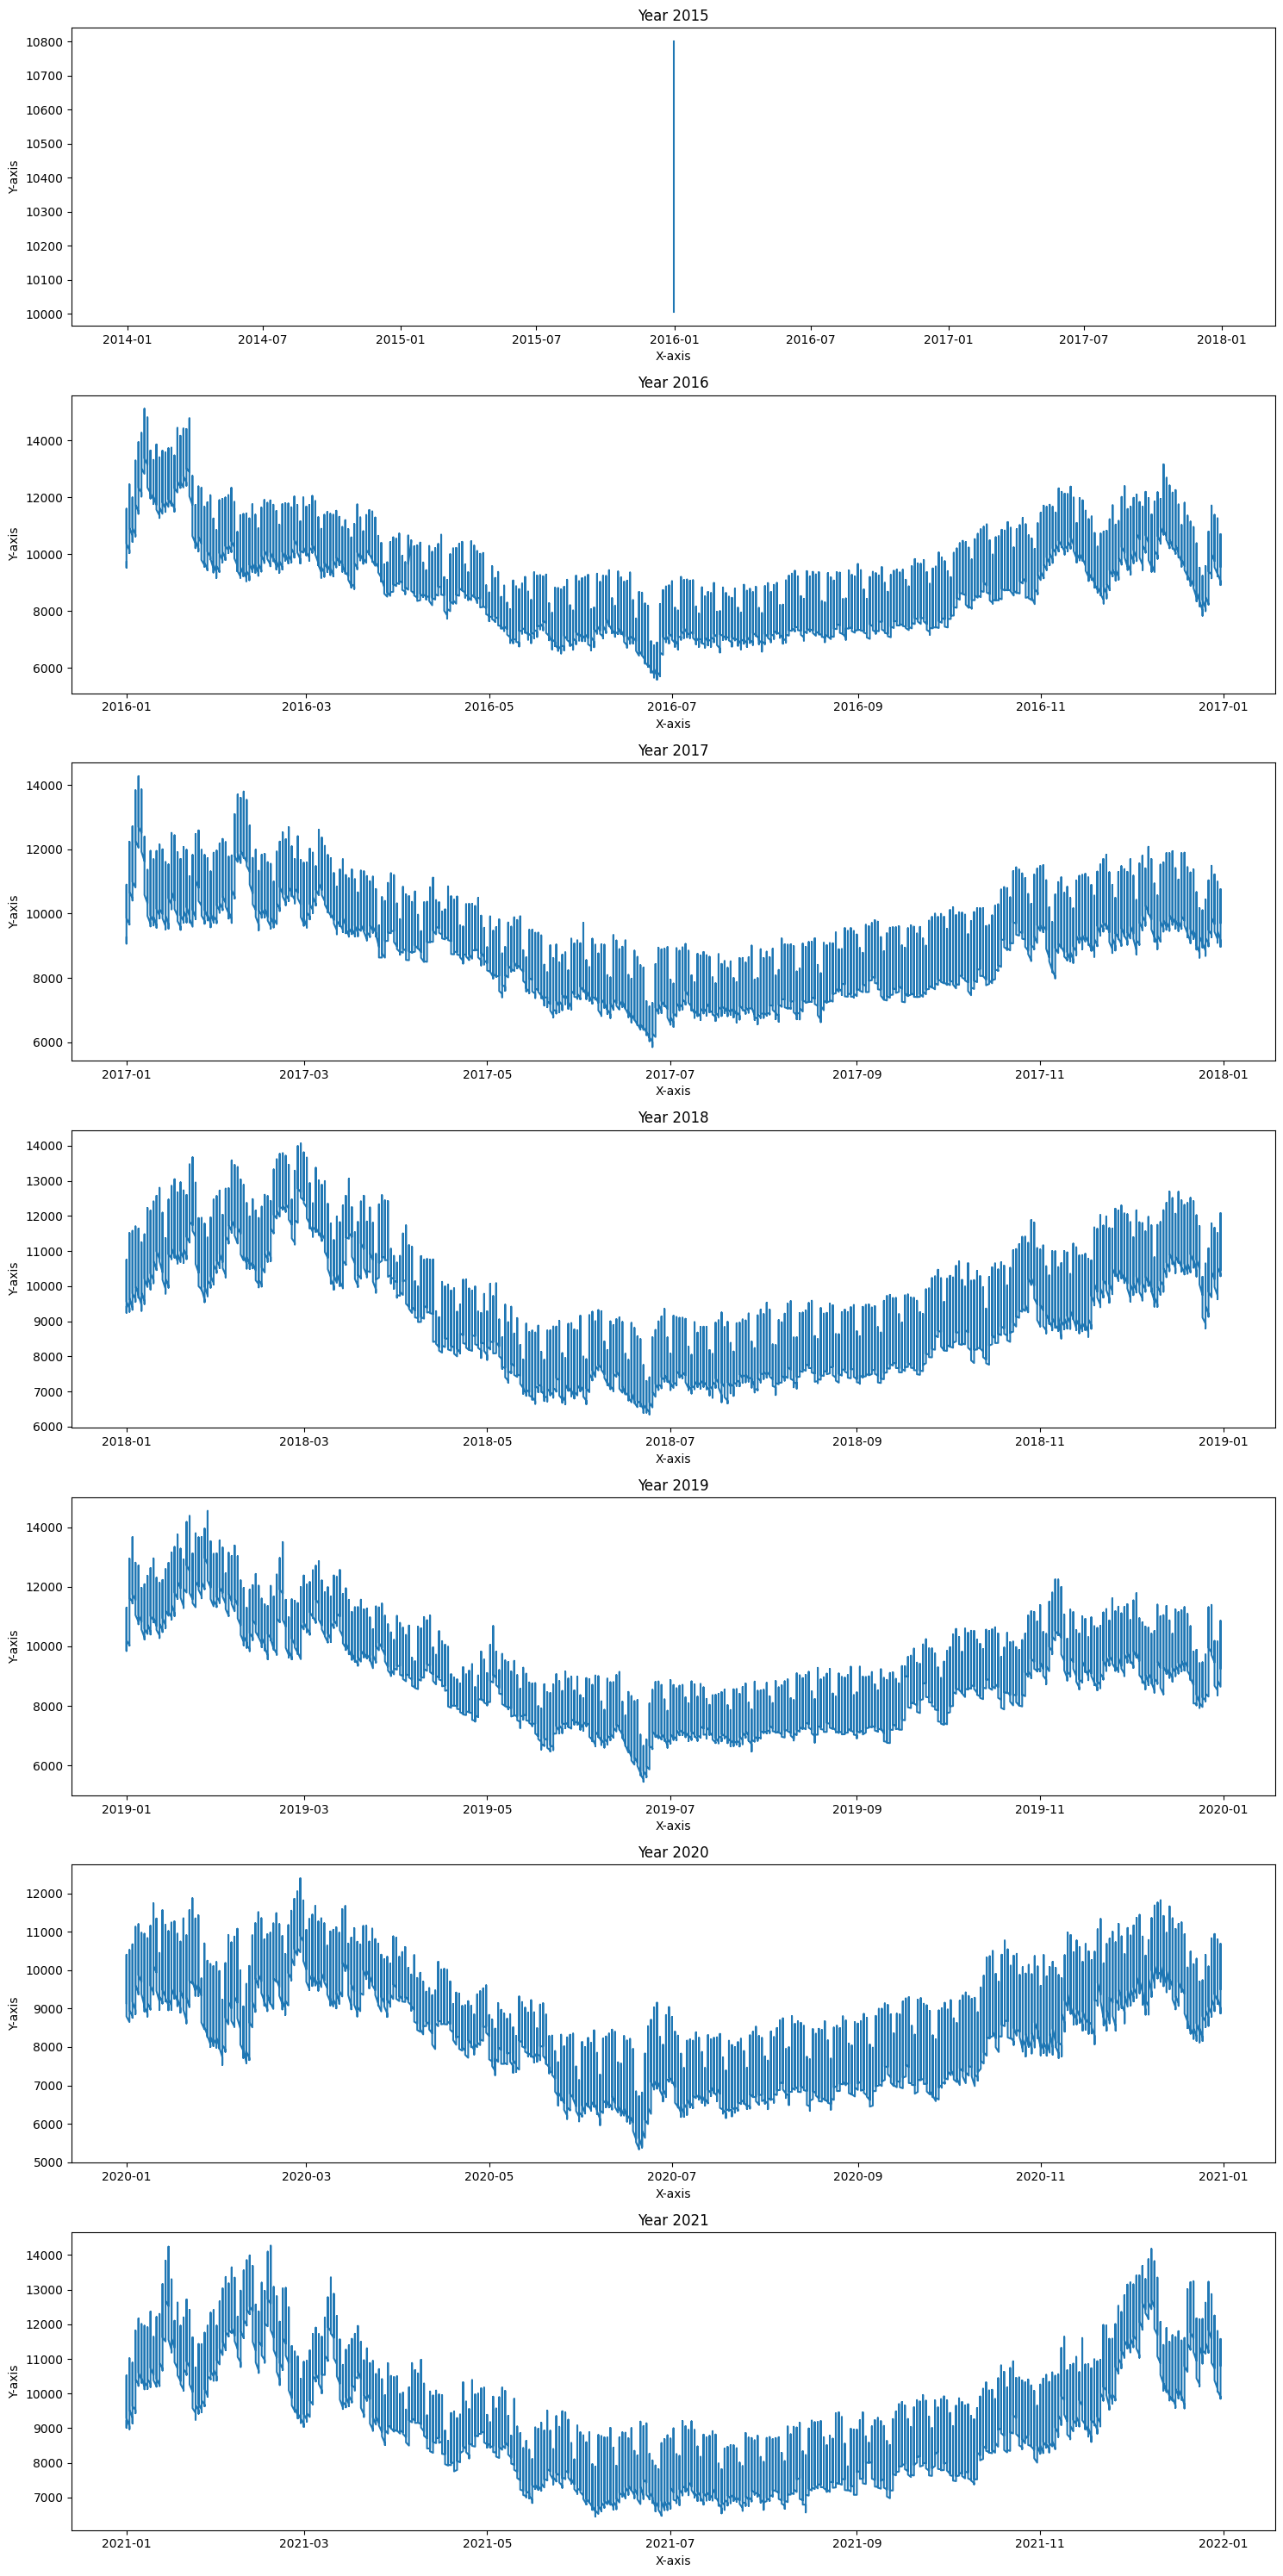

In [307]:
# Group the data by year
grouped_data = dataset.groupby('Year')

# Create a figure and subplots for each year
fig, axes = plt.subplots(nrows=len(grouped_data), ncols=1, figsize=(15, 30))  # Adjust figsize as needed

# Plot data for each year in separate subplots
for i, (year, data) in enumerate(grouped_data):
    ax = axes[i]
    ax.plot(data['Date'], data['Consumption'])  # Replace 'X' and 'Y' with your actual column names
    ax.set_title(f'Year {year}')
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')

# Adjust subplot layout
plt.tight_layout()

# Show the subplots
plt.show()

C:\Users\ianme\AppData\Local\Temp\ipykernel_26312\2029937219.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dataset["Consumption"])


Text(0.5, 1.0, 'Energy Distribution')

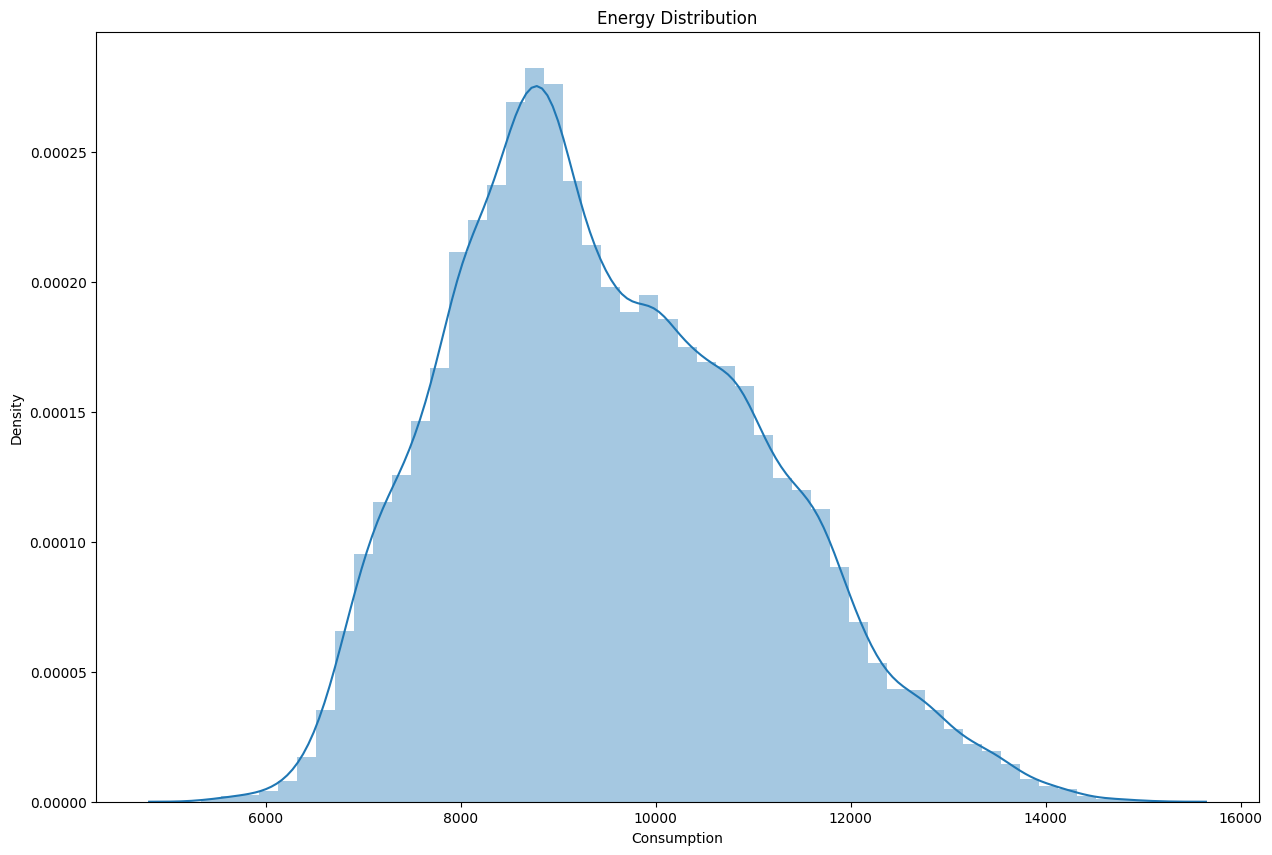

In [308]:
fig = plt.figure(figsize = (15,10))
sns.distplot(dataset["Consumption"])
plt.title("Energy Distribution")

In [309]:
y = dataset["Consumption"]
print(y[0])
y.shape

10800.0


(52966,)

# Normalisation of data and splitting of the data

In [310]:
# Normalize data before model fitting
# it will boost the performance( in neural networks) + transform
from sklearn.preprocessing import MinMaxScaler
# scale of the output and input inthe range 0-1 to match the scale of the layer of LSTM
scaler = MinMaxScaler(feature_range = (0,1)) 
# reshape: convert the univariate 1D array into 2D
y = scaler.fit_transform(np.array(y).reshape(-1,1))
print("Normalizing data before model fitting")


Normalizing data before model fitting


In [311]:
training_size = int(len(y)*0.80)
test_size = len(y)- training_size
val_size = int(training_size*0.20)
train_data , test_data , val_data = y[0:training_size-val_size] , y[training_size:len(y)], y[len(y)-test_size-val_size:len(y)]

# Train and Test data creation

In [312]:
# creating data
def create_dataset(dataset, time_step = 1):
  dataX, dataY = [] , []
  for i in range(len(dataset)-time_step-1):
    a = dataset[i:(i+time_step),0]
    dataX.append(a)
    dataY.append(dataset[i + time_step,0])
  return np.array(dataX), np.array(dataY)

In [313]:
'''
Here 100 hrs values are used to predict the value for 
101 th day, therefore timestep = 100
'''
time_step = 100 
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)
X_val, yval = create_dataset(val_data, time_step)

In [314]:
# reshape train and input-output pairs to match the LSTM input standards
# LSTM input shape (input samples, timestep, features)
# Univariate analysis features = 1
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1],1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1],1)

print("X_train shape: ", X_train.shape)
print("X_test shape: ",X_test.shape)
print("X_val shape: ",X_val.shape)

X_train shape:  (33797, 100, 1)
X_test shape:  (10493, 100, 1)
X_val shape:  (18967, 100, 1)


# Model creation

In [315]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import TensorBoard

model = Sequential()
'''
Three layers of LSTM with Dense layer is created with dropout
'''
# Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True, input_shape = (time_step, 1)))
model.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
# model.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50))
# model.add(Dropout(0.2))

# Adding the output layer
model.add(Dense(units = 1))

# creating tensor board callback to keep track of performance realtime
tensorboard_callback = TensorBoard(log_dir="./logs")

'''
Compiling the model
Model performace can be varied based on using different hyperparameters
'''
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Training the model 

In [316]:
model.fit(X_train, y_train, validation_data = (X_val, yval), verbose = 1, epochs=10, batch_size = 10, callbacks=[tensorboard_callback])

Epoch 1/10
3380/3380 [==============================] - 611s 178ms/step - loss: 0.0024 - val_loss: 3.8850e-04
Epoch 2/10
3380/3380 [==============================] - 591s 175ms/step - loss: 5.3103e-04 - val_loss: 2.9216e-04
Epoch 3/10
3380/3380 [==============================] - 601s 178ms/step - loss: 3.9864e-04 - val_loss: 3.9278e-04
Epoch 4/10
3380/3380 [==============================] - 596s 176ms/step - loss: 3.5431e-04 - val_loss: 2.1922e-04
Epoch 5/10
3380/3380 [==============================] - 527s 156ms/step - loss: 3.1858e-04 - val_loss: 2.2532e-04
Epoch 6/10
3380/3380 [==============================] - 339s 100ms/step - loss: 3.0739e-04 - val_loss: 1.8481e-04
Epoch 7/10
3380/3380 [==============================] - 355s 105ms/step - loss: 2.7557e-04 - val_loss: 1.9413e-04
Epoch 8/10
3380/3380 [==============================] - 384s 114ms/step - loss: 2.6114e-04 - val_loss: 1.9084e-04
Epoch 9/10
3380/3380 [==============================] - 390s 115ms/step - loss: 2.4020e-04 -

# Model evaluation

In [318]:
# Predicting consumption using training data
test_predictions = model.predict(X_test)

# perform inverse transform on the data due to earlier noirmalisation
test_predictions =scaler.inverse_transform(test_predictions)
actual = scaler.inverse_transform(y_test)

test_results = pd.DataFrame(data={'Test Predictions':test_predictions.flatten(), 'Actuals':actual.flatten()})
test_results

328/328 [==============================] - 15s 44ms/step


,Test Predictions,Actuals
0,10219.974609,10549.0
1,10788.744141,10768.0
2,10692.115234,10662.0
3,10273.041016,10377.0
4,10183.589844,9581.0
...,...,...
10488,11694.755859,11575.0
10489,11694.420898,11447.0
10490,11521.579102,11237.0
10491,11122.173828,10914.0


# Plotting the test results against true values

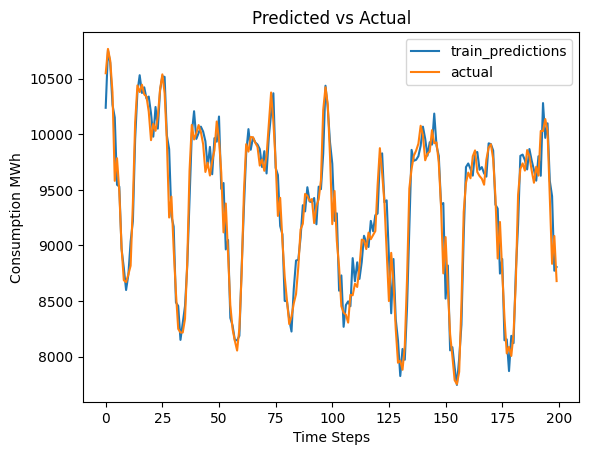

In [319]:
# plotting the predicted results with true values
plt.plot(train_results['Test Predictions'][:200])
plt.plot(train_results['Actuals'][:200])
plt.title("Predicted vs Actual")
plt.legend(['train_predictions','actual'])
plt.xlabel('Time Steps')
plt.ylabel('Consumption MWh')
plt.show()

# Calculating the accuracy of the model using RMSE and MAE

In [320]:
#Mean absolute error of the model for test data
mean_absolute_error(actual,test_predictions)

96.29537451120687

In [321]:
# RMSE score for the test data
math.sqrt(mean_squared_error(actual,test_predictions))

129.94376650144474

In [324]:
# Mean absolute percentage error
mean_absolute_percentage_error(actual, test_predictions)

0.009863134540074758

##### The performance looks good as the MAE between the predicted and actual energy values is around 95 
##### which is good when compared to the average energy consumption values from the Energy distribution graph.

# XGBoost algorithm

In [325]:
'''
Reading data and feature adjustments
Removing unwanted features from the data
'''
Energy_data = pd.read_csv('Energy.csv')
Energy_data = Energy_data.drop(columns=['End time UTC', 'Start time UTC+03:00',
       'End time UTC+03:00'])
Energy_data = Energy_data.rename(columns={'Start time UTC': 'DateTime', 'Electricity consumption in Finland': 'Consumption'})

# creating index same as Datetime
Energy_data.index = pd.to_datetime(Energy_data['DateTime'])
Dataset = Energy_data
Dataset = Dataset.drop(columns = ['DateTime'])

In [326]:
# Data Splitting in the ratio 80:20%
train_data = Dataset.iloc[:int(Dataset.shape[0]*0.8), :]
test_data = Dataset.iloc[train_data.shape[0]:, :]

# data preparation for XGboost

In [327]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df


In [328]:
train_data = create_features(train_data)
test_data = create_features(test_data)

In [329]:
train_data.columns

Index(['Consumption', 'hour', 'dayofweek', 'quarter', 'month', 'year',
       'dayofyear', 'dayofmonth', 'weekofyear'],
      dtype='object')

In [330]:
Features = ['hour', 'dayofweek', 'quarter', 'month', 'year',
       'dayofyear', 'dayofmonth', 'weekofyear']
Target = ['Consumption']

In [331]:
#Data Splitting using features
X_train = train_data[Features]
Y_train = train_data[Target]

X_test = test_data[Features]
Y_test = test_data[Target]

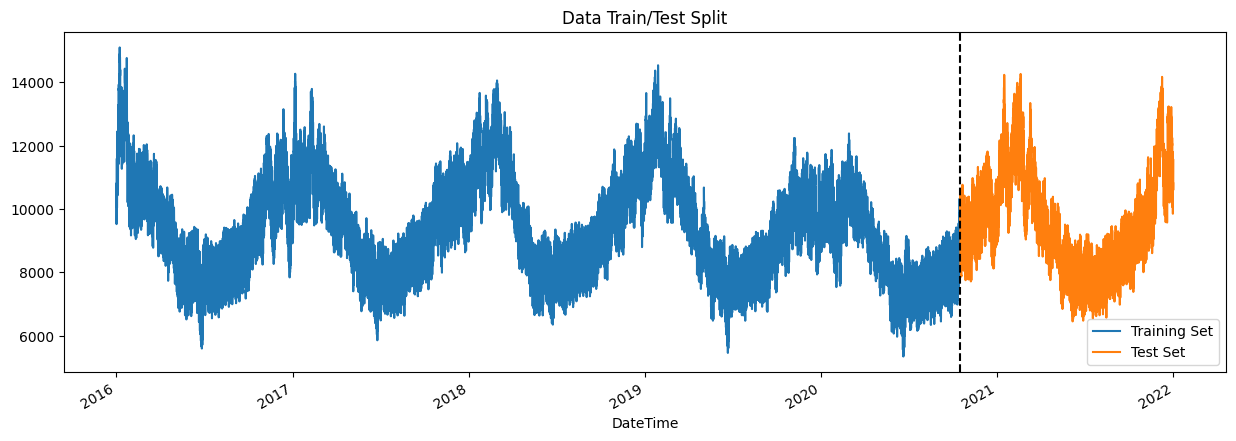

In [339]:
# plottting the train and test data
fig, ax = plt.subplots(figsize=(15, 5))
train_data['Consumption'].plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test_data['Consumption'].plot(ax=ax, label='Test Set')
ax.axvline(df.iloc[int(df.shape[0]*0.8)]['Date'], color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

# XGBoost model

In [333]:
xgb_model = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)

xgb_model.fit(X_train, Y_train)

C:\Users\ianme\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:160: UserWarning: [17:39:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

In [334]:
y_pred = xgb_model.predict(X_test)

# Test data prediction and calculating the accuracy

In [335]:
import pandas as pd

# Assuming Y_test is a 2D array (10, 1)
Y_test_1d = Y_test.values.reshape(-1)

# Now you can use Y_test_1d in your code
test_results = pd.DataFrame(data={'Test Predictions': y_pred, 'Actuals': Y_test_1d})
test_results


,Test Predictions,Actuals
0,9552.099609,9625.0
1,9552.099609,9481.0
2,9552.099609,9529.0
3,9568.586914,9479.0
4,9568.586914,9817.0
...,...,...
10589,10066.864258,11447.0
10590,10066.864258,11237.0
10591,9931.464844,10914.0
10592,9748.976562,10599.0


In [336]:
# RMSE score for the test data
math.sqrt(mean_squared_error(Y_test_1d,y_pred))

1105.9113604069264

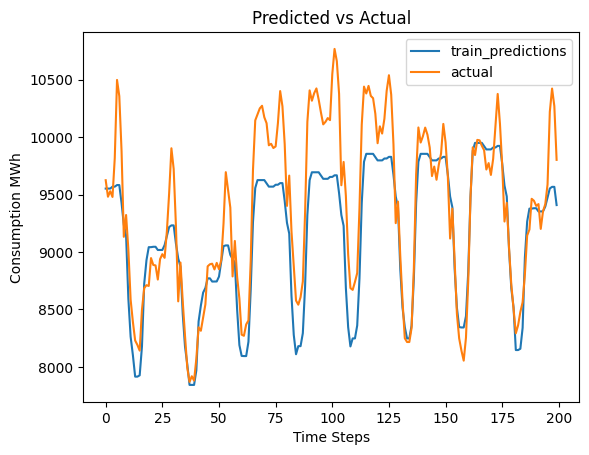

In [337]:
# plotting the predicted results with true values
plt.plot(test_results['Test Predictions'][:200])
plt.plot(test_results['Actuals'][:200])
plt.title("Predicted vs Actual")
plt.legend(['train_predictions','actual'])
plt.xlabel('Time Steps')
plt.ylabel('Consumption MWh')
plt.show()

In [338]:
# Mean absolute percentage error
mean_absolute_percentage_error(Y_test_1d,y_pred)

0.07493674406575836

##### The accuracy is very low when compared to LSTM model, can be increased by varying the hyperparameters